<a href="https://www.nvidia.com/dli"> <img src="../images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# 3.0 명명된 엔터티 인식기 구축

이 노트북에서는 의학 질병 초록에서 질병명을 찾는 애플리케이션을 구축합니다. 이 모델은 목록에서 이름을 "검색"하기보다는 언어의 맥락에서 특정 단어가 질병 참조임을 "인식"합니다.

**[3.1 커맨드 라인에서 토큰 분류](#3.1-커맨드-라인에서-토큰-분류)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1.1 데이터 입력](#3.1.1-데이터-입력)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.1.1 IOB 태깅](#3.1.1.1-IOB-태깅)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1.2 환경 구성 파일](#3.1.2-환경-구성-파일)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1.3 Hydra-Enabled Python 스크립트](#3.1.3-Hydra-Enabled-Python-스크립트)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1.4 예제: 모델 트레이닝](#3.1.4-예제:-모델-트레이닝)<br>
**[3.2 도메인별 트레이닝](#3.2-도메인별-트레이닝)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.2.1 TensorBoard로 결과 시각화하기](#3.2.1-TensorBoard로-결과-시각화하기)<br>
**[3.3 평가](#3.3-평가)**<br>
**[3.4 추론](#3.4-추론)**<br>

NER 태스크의 경우, 텍스트 분류와 동일한 기본 단계에 따라 프로젝트를 구축하고 트레이닝 후 테스트 합니다. 그러나 이번에는, *도메인에 특정된*  BioMegatron 언어 모델에 있는 분류자를 트레이닝 할 예정입니다. BioMegatron은 대용량의 생의학 언어 코퍼스 ([PubMed](https://pubmed.ncbi.nlm.nih.gov/) abstracts와 전체 텍스트 상업적 사용 컬렉션) 에서 사전 훈련된 [BERT](https://arxiv.org/abs/1810.04805)-like [Megatron-LM](https://arxiv.org/pdf/1909.08053.pdf) 모델입니다.  우리는 질병 데이터 세트가 같은 생의학 영역에서 나왔기 때문에 일반 언어 모델과 비교하여 BioMegatron 에서 더 나은 성능을 기대할 수 있습니다. 

BioMegatron에 몇 가지 대안이 있으며 가장 눈에  띄는 모델은 [BioBERT](https://arxiv.org/abs/1901.08746)입니다. BioBERT와 비교하여 BioMegatron은 모델 사이즈에서 더 크며 더 큰 텍스트 코퍼스(말뭉치)에 대해 사전 훈련되어 있습니다. 

---
# 3.1 커맨드 라인에서 토큰 분류
저희가 이번 실습에서 답변하고자 하는 질문은 다음과 같습니다.: 

**의학적 Abstract에서 주어진 문장에는 어떤 질병이 언급되었나요?**<br>

NeMo에서 사용 가능한 NLP 모델을 상기시켜 봅니다. :

In [1]:
!tree nemo/examples/nlp -L 1

nemo/examples/nlp
├── dialogue_state_tracking
├── entity_linking
├── glue_benchmark
├── information_retrieval
├── intent_slot_classification
├── language_modeling
├── machine_translation
├── question_answering
├── text2sparql
├── text_classification
└── token_classification

11 directories, 0 files


우리는 NER을 위해 [토큰 분류](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/token_classification.html) 모델을 활용합니다. 왜냐하면 우리는 질병과 연관되는 단어를 분류하기 위해 "token(토큰)" 레벨에서 분류가 필요하기 때문입니다. 

## 3.1.1 데이터 입력
[1.0 데이터 살펴보기](010_ExploreData.ipynb) 노트북에서 확인한 것과 같이, NER 프로젝트를 위한 데이터세트는 질병 이름을 위해 IOB 태깅이 포함된 문장으로 구성딥니다. 여기서 문장의 각 단어는 명명된 엔티티의 내부(inside), 외부(outside), 시작(beginning)으로 태그가 지정됩니다. 

트레이닝 텍스트와 레이블 파일로는 각각 `text_train.txt`, `labels_train.txt`이 있습니다. 유효성 검증과 테스트 파일은 비슷한 이름 패턴을 따릅니다. 데이터 파일의 위치를 확인해 봅니다. 

In [2]:
NER3_DATA_DIR = '/dli/task/data/NCBI_ner-3'
!ls -lh $NER3_DATA_DIR

total 4.0M
-rw-r--r-- 1 702112 10513  181K Jul 13  2020 dev.tsv
-rw-r--r-- 1 702112 10513     5 Jul 13  2020 label_ids.csv
-rw-r--r-- 1 702112 10513    52 Jul 13  2020 label_stats.tsv
-rw-r--r-- 1 702112 10513   48K Jul 13  2020 labels_dev.txt
-rw-r--r-- 1 702112 10513   49K Jul 13  2020 labels_test.txt
-rw-r--r-- 1 702112 10513  271K Jul 13  2020 labels_train.txt
-rw-r--r-- 1 702112 10513  185K Jul 13  2020 test.tsv
-rw-r--r-- 1 702112 10513  135K Jul 13  2020 text_dev.txt
-rw-r--r-- 1 702112 10513  138K Jul 13  2020 text_test.txt
-rw-r--r-- 1 702112 10513  758K Jul 13  2020 text_train.txt
-rw-r--r-- 1 702112 10513 1023K Jul 13  2020 train.tsv
-rw-r--r-- 1 702112 10513  1.2M Jul 13  2020 train_dev.tsv


In [3]:
# Take a look at the data
print("*****\ntext_test.txt sample\n*****")
!head -n 3 $NER3_DATA_DIR/text_test.txt
print("\n*****\nlabels_test.txt sample\n*****")
!head -n 3 $NER3_DATA_DIR/labels_test.txt

*****
text_test.txt sample
*****
Clustering of missense mutations in the ataxia - telangiectasia gene in a sporadic T - cell leukaemia . 
Ataxia - telangiectasia ( A - T ) is a recessive multi - system disorder caused by mutations in the ATM gene at 11q22 - q23 ( ref . 3 ) . 
The risk of cancer , especially lymphoid neoplasias , is substantially elevated in A - T patients and has long been associated with chromosomal instability . 

*****
labels_test.txt sample
*****
O O O O O O B I I O O O B I I I I O 
B I I O B I I O O O B I I I I O O O O O O O O O O O O O O O O O 
O O O B O O B I O O O O O B I I O O O O O O O O O O 


### 3.1.1.1 IOB 태깅
NER 데이터 세트의 문장과 레이블은 _inside, outside, beginning (IOB)_ 태깅을 사용하여 서로 매핑됩니다. 이 매커니즘은 일반적으로 복수의 이름으로 명명된 엔티티 유형에도 사용할 수 있습니다. :
* B-{CHUNK_TYPE} – Beginning 청크 내에 있는 단어
* I-{CHUNK_TYPE} – 청크 내부(Inside)에 있는 단어들 
* O – 모든 청크의 외부(Outside)에 있음

이번 실습의 경우, 우리는 엔티티 (또는 청크) 유형으로의 "질병"만 찾고 있으므로, 우리는 다음의 3가지 클래스 이외는 식별할 필요가 없습니다. : I, O, B<br>
**세 개의 클래스**
* B - 질병 이름의 시작
* I - 질병 이름 내부에 있는 단어
* O - 모든 질병명을 제외

```text
Identification of APC2 , a homologue of the adenomatous polyposis coli tumour suppressor .
O              O  O    O O O         O  O   B           I         I    I      O          O  
```

다음은 `labels.csv` 파일에 정의되어 있습니다.:

In [4]:
!head $NER3_DATA_DIR/label_ids.csv

O
B
I

우리가 언어 부분 분석에서 명사와 동사와 같은 2 종류의 명명된 엔티티를 찾는다면, 우리는 5 등급 IOB 체계를 사용할 것 입니다.:<br>
**다섯개 클래스**
* B-N - 명사 단어나 구문의 시작
* I-N - 명사 단어나 구문 내부 
* B-V - 동사 단어나 구문 시작
* I-V - 동사 단어나 구문 내부
* O   - 모든 명사나 동사를 제외

해당 주제에 대해 더 자세히 알아보려면 [다음 문서](http://cs229.stanford.edu/proj2005/KrishnanGanapathy-NamedEntityRecognition.pdf)를 확인해 보세요.

NCBI_ner-3 질병 데이터는 다음 [문서](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/token_classification.html#data-input-for-token-classification-model)의 설명에 따라 토큰 분류를 위해 올바른 유형으로 되어 있으므로 우리는 다음 환경 구성 파일을 확인해볼 준비가 되었습니다. 

## 3.1.2 환경 구성 파일
토큰 분류 디렉터리에 대한 자세한 내용은 다음을 참조하십시오.:

In [5]:
TC_DIR = "/dli/task/nemo/examples/nlp/token_classification"
!tree $TC_DIR

/dli/task/nemo/examples/nlp/token_classification
├── conf
│   ├── punctuation_capitalization_config.yaml
│   └── token_classification_config.yaml
├── data
│   ├── get_tatoeba_data.py
│   ├── import_from_iob_format.py
│   └── prepare_data_for_punctuation_capitalization.py
├── punctuation_capitalization_evaluate.py
├── punctuation_capitalization_train.py
├── token_classification_evaluate.py
└── token_classification_train.py

2 directories, 9 files


NER를 위한 환경 구성 파일인  `token_classification_config.yaml`은 파일 위치, 사전 훈련 모델, 하이퍼 파라미터와 같은 모델, 트레이닝, 실험 관리 세부 정보를 지정합니다. 이 패턴은 기존에 텍스트 분류 구성 파일에서 사용되는 것과 동일한 패턴입니다. 우리는 텍스트 분류 프로젝트에서 소개되었던 `OmegaConf` 도구를 사용하여 각 섹션의 세부 사항을 살펴보겠습니다. 

In [6]:
from omegaconf import OmegaConf

CONFIG_DIR = "/dli/task/nemo/examples/nlp/token_classification/conf"
CONFIG_FILE = "token_classification_config.yaml"

config = OmegaConf.load(CONFIG_DIR + "/" + CONFIG_FILE)

# print the model section
print(OmegaConf.to_yaml(config.model))

label_ids: null
class_labels:
  class_labels_file: label_ids.csv
dataset:
  data_dir: ???
  class_balancing: null
  max_seq_length: 128
  pad_label: O
  ignore_extra_tokens: false
  ignore_start_end: false
  use_cache: true
  num_workers: 2
  pin_memory: false
  drop_last: false
train_ds:
  text_file: text_train.txt
  labels_file: labels_train.txt
  shuffle: true
  num_samples: -1
  batch_size: 64
validation_ds:
  text_file: text_dev.txt
  labels_file: labels_dev.txt
  shuffle: false
  num_samples: -1
  batch_size: 64
test_ds:
  text_file: text_dev.txt
  labels_file: labels_dev.txt
  shuffle: false
  num_samples: -1
  batch_size: 64
tokenizer:
  tokenizer_name: ${model.language_model.pretrained_model_name}
  vocab_file: null
  tokenizer_model: null
  special_tokens: null
language_model:
  pretrained_model_name: bert-base-uncased
  lm_checkpoint: null
  config_file: null
  config: null
head:
  num_fc_layers: 2
  fc_dropout: 0.5
  activation: relu
  use_transformer_init: true
optim:
  na

In [7]:
# complete list of supported BERT-like models
from nemo.collections import nlp as nemo_nlp
nemo_nlp.modules.get_pretrained_lm_models_list()

['megatron-bert-345m-uncased',
 'megatron-bert-345m-cased',
 'megatron-bert-uncased',
 'megatron-bert-cased',
 'biomegatron-bert-345m-uncased',
 'biomegatron-bert-345m-cased',
 'bert-base-uncased',
 'bert-large-uncased',
 'bert-base-cased',
 'bert-large-cased',
 'bert-base-multilingual-uncased',
 'bert-base-multilingual-cased',
 'bert-base-chinese',
 'bert-base-german-cased',
 'bert-large-uncased-whole-word-masking',
 'bert-large-cased-whole-word-masking',
 'bert-large-uncased-whole-word-masking-finetuned-squad',
 'bert-large-cased-whole-word-masking-finetuned-squad',
 'bert-base-cased-finetuned-mrpc',
 'bert-base-german-dbmdz-cased',
 'bert-base-german-dbmdz-uncased',
 'cl-tohoku/bert-base-japanese',
 'cl-tohoku/bert-base-japanese-whole-word-masking',
 'cl-tohoku/bert-base-japanese-char',
 'cl-tohoku/bert-base-japanese-char-whole-word-masking',
 'TurkuNLP/bert-base-finnish-cased-v1',
 'TurkuNLP/bert-base-finnish-uncased-v1',
 'wietsedv/bert-base-dutch-cased',
 'distilbert-base-uncased

`model`섹션에서는 모든 데이터 파일을 포함하는 `dataset.data_dir` 경로가 필요합니다. 현재 사용하고 있는 실제 파일 이름은 이미 기본 값을 만족하고 있으므로 재정의 할 필요는 없습니다. 

첫 번째 시도에서는, 우리는 `language_model.pretrained_model_name`를  `bert-base-cased`로 재정의함으로서 다른 실험에서 도메인 특성을 가지고 있는`biomegatron-bert-345m-cased`와 결과 값을 비교할 수 있습니다. 우리는 BioMegatron을 실행하기 위해 메모리 공간을 남겨야 하므로, 우리는 `dataset.max_seq_length`와 `batch_size` 값을 줄이도록 하겠습니다.

In [8]:
# print the trainer section
print(OmegaConf.to_yaml(config.trainer))

gpus: 1
num_nodes: 1
max_epochs: 5
max_steps: null
accumulate_grad_batches: 1
gradient_clip_val: 0.0
amp_level: O0
precision: 16
accelerator: ddp
checkpoint_callback: false
logger: false
log_every_n_steps: 1
val_check_interval: 1.0
resume_from_checkpoint: null



효율성을 위해 `amp_level`을 'O1'로 설정할 수 있습니다. 우리가 비교하고자 하는 모델들이 크고 실행하는 데 오랜 시간이 소요되기 때문에 우리는 `max_epochs` 값을 작은 값으로 재정의할 것입니다. 

In [9]:
# print the experiment manager section
print(OmegaConf.to_yaml(config.exp_manager))

exp_dir: null
name: token_classification_model
create_tensorboard_logger: true
create_checkpoint_callback: true



지금은 `exp_manger` 기본 설정을 변경할 필요가 없습니다. 

## 3.1.3 Hydra-Enabled Python 스크립트
파이썬 스크립트인 `token_classification_train.py`와 `token_evaluate.py`는 환경 구성 파일에 정의된 토큰 분류 실험을 실행하기 위해 필요한 모든 것을 캡슐화 합니다. 이 경우, 트레이닝과 평가는 별도로 수행될 것으로 예상됩니다. 텍스트 분류와 마찬가지로 두 스크립트 모두 Facebook의 [Hydra](https://hydra.cc/) 도구를 구성 관리를 위해 활용함으로서 필요에 따라 구성 파일 값을 재정의함으로서 전체 실험을 커맨드 라인에서 실행할 수 있습니다. 

다시 설명하면, 우리가 변경하거나 재정의해야하는 파라미터 값은 다음과 같습니다.:

* `model.language_model.pretrained_model_name`: 'bert-base-cased'
* `model.dataset.data_dir`:  /dli/task/data/NCBI_ner-3
* `model.dataset.max_seq_length`: 64
* `model.train_ds.batch_size`: 32
* `model.val_ds.batch_size`:  32
* `model.test_ds.batch_size`:  32
* `trainer.amp_level`:  "O1"
* `trainer.max_epochs`:  3

## 3.1.4 예제: 모델 트레이닝

텍스트 분류 노트북에 있었던 유사한 실험을 실행한 것과 같이 `token_classification_train.py` 트레이닝 스크립트를 실행합니다. 

재정의를 위한 새로운 값들은 아래 셀에 제공됩니다. 적절한 재정의와 함께 명령문을 추가하고 셀을 실행합니다. 실습 수행에 어려움이 있는 경우, [솔루션](solutions/ex3.1.4.ipynb) 을 참고하세요.

In [10]:
%%time
# The training takes about 2 minutes to run
   
TOKEN_DIR = "/dli/task/nemo/examples/nlp/token_classification"

# set the values we want to override
PRETRAINED_MODEL_NAME = 'bert-base-cased'
DATA_DIR = '/dli/task/data/NCBI_ner-3'
MAX_SEQ_LENGTH = 64
BATCH_SIZE = 32
AMP_LEVEL = 'O1'
MAX_EPOCHS = 3

# Override the config values in the command line
!python $TOKEN_DIR/token_classification_train.py \
        model.language_model.pretrained_model_name=$PRETRAINED_MODEL_NAME \
        model.dataset.data_dir=$DATA_DIR \
        model.dataset.max_seq_length=$MAX_SEQ_LENGTH \
        model.train_ds.batch_size=$BATCH_SIZE \
        model.validation_ds.batch_size=$BATCH_SIZE \
        model.test_ds.batch_size=$BATCH_SIZE \
        trainer.amp_level=$AMP_LEVEL \
        trainer.max_epochs=$MAX_EPOCHS

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
[NeMo I 2024-03-04 05:23:00 exp_manager:216] Experiments will be logged at /dli/task/nemo_experiments/token_classification_model/2024-03-04_05-23-00
[NeMo I 2024-03-04 05:23:00 exp_manager:563] TensorboardLogger has been set up
[NeMo I 2024-03-04 05:23:00 token_classification_train:109] Config: pretrained_model: null
    trainer:
      gpus: 1
      num_nodes: 1
      max_epochs: 3
      max_steps: null
      accumulate_grad_batches: 1
      gradient_clip_val: 0.0
      amp_level: O1
      precision: 16
      accelerator: ddp
      checkpoint_callback: false
      logger: false
      log_every_n_steps: 1
      val_check_interval: 1.0
      resume_from_checkpoint: null
    exp_manager:
      exp_dir: null
      name: token_classification_model
      create_tensorboard_logger: true
      create_checkpoint_callback: true
    model:
      label_ids: null
      class_labels:
        class_

결과값은 어땠나요? 로그에 다음과 같은 항목이 포함되어 있을 것입니다.

```
    label                                                precision    recall       f1           support   
    O (label_id: 0)                                         99.34      99.35      99.34      21648
    B (label_id: 1)                                         85.86      89.21      87.50        769
    I (label_id: 2)                                         91.74      89.00      90.35       1073
    -------------------
    micro avg                                               98.54      98.54      98.54      23490
    macro avg                                               92.31      92.52      92.40      23490
    weighted avg                                            98.55      98.54      98.55      23490
    
Epoch 2: 100%|█| 199/199 [00:15<00:00, 12.45it/s, loss=0.0251, v_num=4-43, val_l
```

---
# 3.2 도메인별 트레이닝

다른 실험을 시도해 봅니다. 이번에는 `model.language_model.pretrained_model_name`를 `biomegatron-bert-345m-cased`로 재정의합니다. 이 모델은 3억 4,500만 개의 파라미터를 가진 대형 모델입니다. 따라서 실행 하는 데 시간이 오래 걸립니다. 

In [11]:
%%time
# The training takes about 5-6 minutes to run
   
TOKEN_DIR = "/dli/task/nemo/examples/nlp/token_classification"

# set the values we want to override
PRETRAINED_MODEL_NAME = 'biomegatron-bert-345m-cased'
DATA_DIR = '/dli/task/data/NCBI_ner-3'
MAX_SEQ_LENGTH = 64
BATCH_SIZE = 32
AMP_LEVEL = 'O1'
MAX_EPOCHS = 3

# Override the config values in the command line
!python $TOKEN_DIR/token_classification_train.py \
        model.language_model.pretrained_model_name=$PRETRAINED_MODEL_NAME \
        model.dataset.data_dir=$DATA_DIR \
        model.dataset.max_seq_length=$MAX_SEQ_LENGTH \
        model.train_ds.batch_size=$BATCH_SIZE \
        model.validation_ds.batch_size=$BATCH_SIZE \
        model.test_ds.batch_size=$BATCH_SIZE \
        trainer.amp_level=$AMP_LEVEL \
        trainer.max_epochs=$MAX_EPOCHS

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
[NeMo I 2024-03-04 05:25:08 exp_manager:216] Experiments will be logged at /dli/task/nemo_experiments/token_classification_model/2024-03-04_05-25-08
[NeMo I 2024-03-04 05:25:08 exp_manager:563] TensorboardLogger has been set up
[NeMo I 2024-03-04 05:25:08 token_classification_train:109] Config: pretrained_model: null
    trainer:
      gpus: 1
      num_nodes: 1
      max_epochs: 3
      max_steps: null
      accumulate_grad_batches: 1
      gradient_clip_val: 0.0
      amp_level: O1
      precision: 16
      accelerator: ddp
      checkpoint_callback: false
      logger: false
      log_every_n_steps: 1
      val_check_interval: 1.0
      resume_from_checkpoint: null
    exp_manager:
      exp_dir: null
      name: token_classification_model
      create_tensorboard_logger: true
      create_checkpoint_callback: true
    model:
      label_ids: null
      class_labels:
        class_

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



100% [..................................................] 665251537 / 665251537using world size: 1, data-parallel-size: 1, tensor-model-parallel size: 1, pipeline-model-parallel size: 1 
setting global batch size to 1
using torch.float32 for parameters ...
------------------------ arguments ------------------------
  adam_beta1 ...................................... 0.9
  adam_beta2 ...................................... 0.999
  adam_eps ........................................ 1e-08
  adlr_autoresume ................................. False
  adlr_autoresume_interval ........................ 1000
  apply_query_key_layer_scaling ................... True
  apply_residual_connection_post_layernorm ........ False
  attention_dropout ............................... 0.1
  attention_softmax_in_fp32 ....................... False
  bert_load ....................................... None
  bias_dropout_fusion ............................. False
  bias_gelu_fusion ................................ 

## 3.2.1 TensorBoard로 결과 시각화하기
[experiment manager](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/core/core.html?highlight=tensorboard#experiment-manager) 는 텐서보드로 볼 수 있는 결과들을 저장합니다. <br>
인스턴스에 대한 [TensorBoard](/tensorboard/)를 열어 살펴보십시오.

실행한 모델들의 결과를 비교하려면 "f1" 스케일러를 선택합니다. 여러분은 함께 실행한 모든 모델을 보실 수도 있고, 개별 모델을 선택하여 비교할 수 있습니다. 이번 예제 비교에서는 5개의 Epoch가 실행되었습니다. 주황색 실선은 `bert-base-cased` 모델의 결과를 보여주고 파란색 실선은 `biomegatron-bert-345m-cased` 모델의 결과를 보여줍니다. BioMegatron 모델은 질병 이름을 더 잘 식별할 수 있기 때문에 매우 빠르게 잘 동작합니다. 5개 epoch 이후에 여전히 약간 높은 f1을 가지고 있습니다. 여러분의 프로젝트를 위해 선택하는 모델은 메모리, 시간, 성능 요구사항의 제약 조건에 따라 달라질 수 있습니다. 여러분의 결과가 학습 알고리즘의 임의성으로 예시와 다를 수 있음을 안내드립니다. 

<img src="images/tensorboard_02.png" width=800px>

---
# 3.3 평가

In [12]:
# Restart the kernel
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

테스트 세트를 통해 모델을 평가하려면 `.nemo` 훈련된 모델의 위치를 지정해야 합니다. 각 실험은 `nemo_experiments` 아래의 시간 표기한 디렉토리에 결과를 실행 합니다. 드릴 다운하면 최종 `token_classification_model.nemo` 가 있는 `checkpoints` 폴더를 찾을 수 있습니다. 다음 셀에서는 Python 로직의 일부를 사용하여 모델 목록을 캡쳐하고 최신 모델 목록을 식별해 봅니다. 

In [1]:
import glob

nemo_model_paths = glob.glob('nemo_experiments/token_classification_model/*/checkpoints/*.nemo')

# Sort newest first
nemo_model_paths.sort(reverse=True)
print("The latest model is \n{}".format(nemo_model_paths[0]))

The latest model is 
nemo_experiments/token_classification_model/2024-03-04_05-25-08/checkpoints/token_classification_model.nemo


테스트 세트에 대해 평가를 진행하는 몇 가지 방법이 있습니다.:
1. `token_classification_evaluate.py`를 기존과 같은 재정의 값과 함께 실행하고 `pretrained_model`를 `.nemo` 형식 값으로 추가 재정의 합니다. 

```text
   !python $TOKEN_DIR/token_classification_evaluate.py \
        model.dataset.data_dir=$DATA_DIR \
        model.dataset.max_seq_length=$MAX_SEQ_LENGTH \
        model.train_ds.batch_size=$BATCH_SIZE \
        model.validation_ds.batch_size=$BATCH_SIZE \
        model.test_ds.batch_size=$BATCH_SIZE \
        model.language_model.pretrained_model_name=$PRETRAINED_MODEL_NAME \
        pretrained_model=$LATEST_MODEL
```
        
2. 트레이닝된 모델 체크포인트를 복원하여 모델을 인스턴스화 하고 NeMo 메소드를 실행하여 테스트 세트를 평가합니다.<br>
   우리는 이 방법으로 실습을 진행합니다. 

In [2]:
# Instantiate the model by restoring from the .nemo checkpoint
from nemo.collections import nlp as nemo_nlp

LATEST_MODEL = nemo_model_paths[0]
model = nemo_nlp.models.TokenClassificationModel.restore_from(LATEST_MODEL)

Using bos_token, but it is not set yet.
Using eos_token, but it is not set yet.
[NeMo W 2024-03-04 05:31:05 modelPT:137] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    text_file: text_train.txt
    labels_file: labels_train.txt
    shuffle: true
    num_samples: -1
    batch_size: 32
    
[NeMo W 2024-03-04 05:31:05 modelPT:144] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    text_file: text_dev.txt
    labels_file: labels_dev.txt
    shuffle: false
    num_samples: -1
    batch_size: 32
    
[NeMo W 2024-03-04 05:31:05 modelPT:151] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple_test_data() method and provide a valid configuration fi

using world size: 1, data-parallel-size: 1, tensor-model-parallel size: 1, pipeline-model-parallel size: 1 
setting global batch size to 1
using torch.float32 for parameters ...
------------------------ arguments ------------------------
  adam_beta1 ...................................... 0.9
  adam_beta2 ...................................... 0.999
  adam_eps ........................................ 1e-08
  adlr_autoresume ................................. False
  adlr_autoresume_interval ........................ 1000
  apply_query_key_layer_scaling ................... True
  apply_residual_connection_post_layernorm ........ False
  attention_dropout ............................... 0.1
  attention_softmax_in_fp32 ....................... False
  bert_load ....................................... None
  bias_dropout_fusion ............................. False
  bias_gelu_fusion ................................ False
  block_data_path ................................. None
  checkpoint_act

[NeMo W 2024-03-04 05:31:08 megatron_bert:185] Megatron-lm checkpoint version not found. Setting checkpoint_version to 0.


[NeMo I 2024-03-04 05:31:08 megatron_bert:192] Checkpoint loaded from from /root/.cache/torch/megatron/biomegatron-bert-345m-cased
[NeMo I 2024-03-04 05:31:09 modelPT:434] Model TokenClassificationModel was successfully restored from nemo_experiments/token_classification_model/2024-03-04_05-25-08/checkpoints/token_classification_model.nemo.


`evaluate_from_file` 메소드를 사용하여 테스트 세트로 모델을 평가합니다.`add_confusion_matrix`를 True로 설정하여 모델이 얼마다 잘 했는지 시각적으로 표현합니다. .

[NeMo I 2024-03-04 05:31:31 token_classification_dataset:116] Setting Max Seq length to: 157
[NeMo I 2024-03-04 05:31:31 data_preprocessing:299] Some stats of the lengths of the sequences:
[NeMo I 2024-03-04 05:31:31 data_preprocessing:301] Min: 4 |                  Max: 157 |                  Mean: 37.204255319148935 |                  Median: 35.0
[NeMo I 2024-03-04 05:31:31 data_preprocessing:307] 75 percentile: 46.00
[NeMo I 2024-03-04 05:31:31 data_preprocessing:308] 99 percentile: 94.22


[NeMo W 2024-03-04 05:31:31 token_classification_dataset:145] 0 are longer than 157


[NeMo I 2024-03-04 05:31:31 token_classification_dataset:148] *** Example ***
[NeMo I 2024-03-04 05:31:31 token_classification_dataset:149] i: 0
[NeMo I 2024-03-04 05:31:31 token_classification_dataset:150] subtokens: [CLS] C ##luster ##ing of miss ##ense mutations in the at ##ax ##ia - te ##lang ##ie ##ct ##asi ##a gene in a s ##poradic T - cell le ##uka ##emia . [SEP]
[NeMo I 2024-03-04 05:31:31 token_classification_dataset:151] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-03-04 05:31:31 token_classification_dataset:152] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

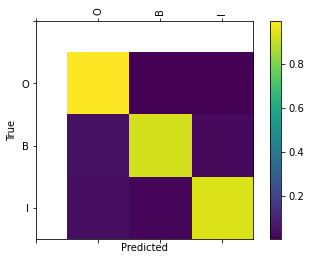

In [3]:
import os.path

DATA_DIR = '/dli/task/data/NCBI_ner-3'
OUTPUT_DIR = '/dli/task/nemo_experiments/token_classification_model/logs'
model.evaluate_from_file(
    text_file=os.path.join(DATA_DIR, 'text_test.txt'),
    labels_file=os.path.join(DATA_DIR, 'labels_test.txt'),
    output_dir=OUTPUT_DIR,
    add_confusion_matrix=True,
    normalize_confusion_matrix=True,
    batch_size=1
)

결과 값은 다음과 같이 표시 됩니다.

```
[NeMo I 2021-06-29 00:42:16 token_classification_model:499]                  precision    recall  f1-score   support
    
    O (label id: 0)     0.9958    0.9910    0.9934     22450
    B (label id: 1)     0.8886    0.9135    0.9009       960
    I (label id: 2)     0.8724    0.9374    0.9038      1087
    
           accuracy                         0.9856     24497
          macro avg     0.9189    0.9473    0.9327     24497
       weighted avg     0.9861    0.9856    0.9858     24497


최종 Confusion 매트릭트 시각화는 밝은 대각선을 보여주며, 이는 예측 레이블이 모든 레이블 유형 (IOB)에 대해 높은 정확도로 실제 레이블과 일치했음을 나타냅니다. 
```

<img src="images/ner_confusion_matrix.png">

---
# 3.4 추론
쿼리 목록에 대한 추론을 실행하려면, `add_predictions` 메소드와 함께 이미 로드된 동일한 모델을 사용하십시오 .

In [4]:
queries = ["Clustering of missense mutations in the ataxia - telangiectasia gene in a sporadic T - cell leukaemia . ",
    "Ataxia - telangiectasia ( A - T ) is a recessive multi - system disorder caused by mutations in the ATM gene at 11q22 - q23 ( ref . 3 ) . ",
    "The risk of cancer , especially lymphoid neoplasias , is substantially elevated in A - T patients and has long been associated with chromosomal instability . ",
    "By analysing tumour DNA from patients with sporadic T - cell prolymphocytic leukaemia ( T - PLL ) , a rare clonal malignancy with similarities to a mature T - cell leukaemia seen in A - T , we demonstrate a high frequency of ATM mutations in T - PLL . ",
    "In marked contrast to the ATM mutation pattern in A - T , the most frequent nucleotide changes in this leukaemia were missense mutations . ",
    "These clustered in the region corresponding to the kinase domain , which is highly conserved in ATM - related proteins in mouse , yeast and Drosophila . ",
    "The resulting amino - acid substitutions are predicted to interfere with ATP binding or substrate recognition . ",
    "Two of seventeen mutated T - PLL samples had a previously reported A - T allele . ",
    "In contrast , no mutations were detected in the p53 gene , suggesting that this tumour suppressor is not frequently altered in this leukaemia . ",
    "Occasional missense mutations in ATM were also found in tumour DNA from patients with B - cell non - Hodgkins lymphomas ( B - NHL ) and a B - NHL cell line . "
          ]

In [5]:
results = model.add_predictions(queries, output_file='predictions.txt')

[NeMo I 2024-03-04 05:31:57 token_classification_dataset:116] Setting Max Seq length to: 74
[NeMo I 2024-03-04 05:31:57 data_preprocessing:299] Some stats of the lengths of the sequences:
[NeMo I 2024-03-04 05:31:57 data_preprocessing:301] Min: 20 |                  Max: 74 |                  Mean: 38.1 |                  Median: 34.0
[NeMo I 2024-03-04 05:31:57 data_preprocessing:307] 75 percentile: 44.25
[NeMo I 2024-03-04 05:31:57 data_preprocessing:308] 99 percentile: 71.66


[NeMo W 2024-03-04 05:31:57 token_classification_dataset:145] 0 are longer than 74


[NeMo I 2024-03-04 05:31:57 token_classification_dataset:148] *** Example ***
[NeMo I 2024-03-04 05:31:57 token_classification_dataset:149] i: 0
[NeMo I 2024-03-04 05:31:57 token_classification_dataset:150] subtokens: [CLS] C ##luster ##ing of miss ##ense mutations in the at ##ax ##ia - te ##lang ##ie ##ct ##asi ##a gene in a s ##poradic T - cell le ##uka ##emia . [SEP]
[NeMo I 2024-03-04 05:31:57 token_classification_dataset:151] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-03-04 05:31:57 token_classification_dataset:152] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-03-04 05:31:57 token_classification_dataset:153] subtokens_mask: 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [6]:
!cat predictions.txt

Clustering of missense mutations in the ataxia[B] [I]- telangiectasia[I] gene in a sporadic T[B] [I]- cell[I] leukaemia[I] .
Ataxia[B] [I]- telangiectasia[I] ( A[B] [I]- T[I] ) is a recessive[B] multi[I] [I]- system[I] disorder[I] caused by mutations in the ATM gene at 11q22 - q23 ( ref . 3 ) .
The risk of cancer[B] , especially lymphoid[B] neoplasias[I] , is substantially elevated in A[B] [I]- T[I] patients and has long been associated with chromosomal instability .
By analysing tumour[B] DNA from patients with sporadic[B] T[I] [I]- cell[I] prolymphocytic[I] leukaemia[I] ( T[B] [I]- PLL[I] ) , a rare clonal[B] malignancy[B] with similarities to a mature[B] T[I] [I]- cell[I] leukaemia[I] seen in A[B] [I]- T[I] , we demonstrate a high frequency of ATM mutations in T[B] [I]- PLL[I] .
In marked contrast to the ATM mutation pattern in A[B] [I]- T[I] , the most frequent nucleotide changes in this leukaemia[B] were missense mutations .
These clustered in the region corresponding to the kinas

---
<h2 style="color:green;">축하합니다!</h2>

여러분은 NeMo를 마스터하고 다음을 배웠습니다:
* 명명된 엔티티 인식기를 구축하는 방법 
* 도메인별 모델에 적용하는 방법
* 체크포인트에서 쿼리를 사용하여 NER 모델을 테스트하는 방법

<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>